# Tarea 2: Clasificación - Cervezas Premium

- Cristopher Corona Velasco
- 743940

### Cargamos y separamos datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# librerias de sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# configuracion visual
sns.set(style="whitegrid")

# cargar datos
# nota: asegúrate de que el nombre del archivo sea el correcto
df = pd.read_csv('beer_quality_lab.csv') 

# vemos que trae
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   amargor_IBU               600 non-null    float64
 1   alcohol_ABV               600 non-null    float64
 2   color_SRM                 600 non-null    float64
 3   densidad_original         600 non-null    float64
 4   lupulo_aroma              600 non-null    object 
 5   levadura                  600 non-null    object 
 6   tiempo_fermentacion_dias  600 non-null    float64
 7   carbonatacion_vol         600 non-null    float64
 8   es_premium                600 non-null    int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 42.3+ KB


,amargor_IBU,alcohol_ABV,color_SRM,densidad_original,lupulo_aroma,levadura,tiempo_fermentacion_dias,carbonatacion_vol,es_premium
0,31.745423,3.747607,14.871837,1.044902,medio,BE256,10.729270,1.985522,0
1,48.106908,6.704599,7.947215,1.070265,medio,BE256,26.619715,1.860536,1
2,39.616689,5.886887,7.128324,1.057311,medio,BE256,12.350084,1.732928,0
3,57.590935,4.579238,9.077901,1.052243,bajo,BE256,11.045210,2.244579,0
4,48.154002,2.395786,14.718901,1.054810,medio,K97,7.491980,2.309706,0


### Preprocesamos y hacemos el split
Transformamos las variables categóricas con One Hot Encoding y separamos el dataset en 80% entrenamiento y 20% prueba. También estandarizamos los datos.

In [2]:
# codificacion de variables categoricas
df_encoded = pd.get_dummies(df, columns=['lupulo_aroma', 'levadura'], drop_first=True)

# definimos cvariables yb target
X = df_encoded.drop('es_premium', axis=1)
y = df_encoded['es_premium']

# separamos train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # solo fit con train
X_test_scaled = scaler.transform(X_test)

# cointeo de observaciones por clase
print("Observaciones por clase (Total):")
print(y.value_counts())
print("\nObservaciones en Train:")
print(y_train.value_counts())
print("\nObservaciones en Test:")
print(y_test.value_counts())

Observaciones por clase (Total):
es_premium
0    485
1    115
Name: count, dtype: int64

Observaciones en Train:
es_premium
0    388
1     92
Name: count, dtype: int64

Observaciones en Test:
es_premium
0    97
1    23
Name: count, dtype: int64


### Regresion logistica

Entrenamos un modelo de RL con los datos ya estandarizados y evaluamos.

**¿Por qué F1-Score es más adecuado que Accuracy aquí?**


En este dataset las clases están desbalanceadas. La regresión logística tiene una accuracy global de 0.975, pero esta mezcla el desempeño de las dos clases y se puede ver mejor de lo que es solo porque el modelo acierta muy bien la clase mayoritaria.

Si vemos solo la clase premium (1), el modelo da más o menos:

precisión = 0.92

recall = 0.96

F1 = 0.94

El F1-score junta precisión y recall y rerfleja mejor el equilibrio entre:

- no dejar ir demasiadas cervezas premium (recall alto)

- no marcar como premium cervezas que no lo son (precisión alta)

In [3]:
# entrenamos el modelo
# random_state para reproducibilidad
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train)

# predecimos en test
y_pred_log = log_model.predict(X_test_scaled)

# metricas
print("--- Reporte de Clasificación (Regresión Logística) ---")
print(classification_report(y_test, y_pred_log))

# matrriz de confusion para errores exactos
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred_log)
print(cm)

--- Reporte de Clasificación (Regresión Logística) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        97
           1       0.92      0.96      0.94        23

    accuracy                           0.97       120
   macro avg       0.95      0.97      0.96       120
weighted avg       0.98      0.97      0.98       120


--- Matriz de Confusión ---
[[95  2]
 [ 1 22]]


### Hacemos el SVC
Entrenamos un modelo SVC con kernel RBF. Para encontrar la mejor configuracion, hicimos una búsqueda de hiperparámetros con Grid Search.

In [4]:
# definimos rejilla de parmetros
# C: controla la penalizacion de errores
# gamma: define que tanto influye un solo dato
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['rbf']
}

# configuramos gridsearch
# cv=3
grid = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    refit=True,
    cv=3,
    scoring='f1'   # usamos f1 por el desbalanceo
)


# train
grid.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

# prediccion con el mejor modelo
y_pred_svc = grid.predict(X_test_scaled)

print("\n--- Reporte de Clasificación (SVC - Mejor Modelo) ---")
print(classification_report(y_test, y_pred_svc))

Mejores hiperparámetros encontrados:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

--- Reporte de Clasificación (SVC - Mejor Modelo) ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        97
           1       0.87      0.87      0.87        23

    accuracy                           0.95       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.95      0.95      0.95       120



### Random Forest
Entrenamos un Random Forest. Usamos validación cruzada con $k=5$ para obtener métricas más robustas (promedio de 5 intentos). FinAl final, graficamos las variables que el modelo considera más importantes.

--- Resultados Validación Cruzada (Promedio k=5) ---
Precision promedio: 0.9028
Recall promedio:    0.7731
F1-Score promedio:  0.8278


/var/folders/gb/zmtgsn054xj5ftd4w025zvpm0000gn/T/ipykernel_81011/3327373600.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=df_importancia, palette='viridis')


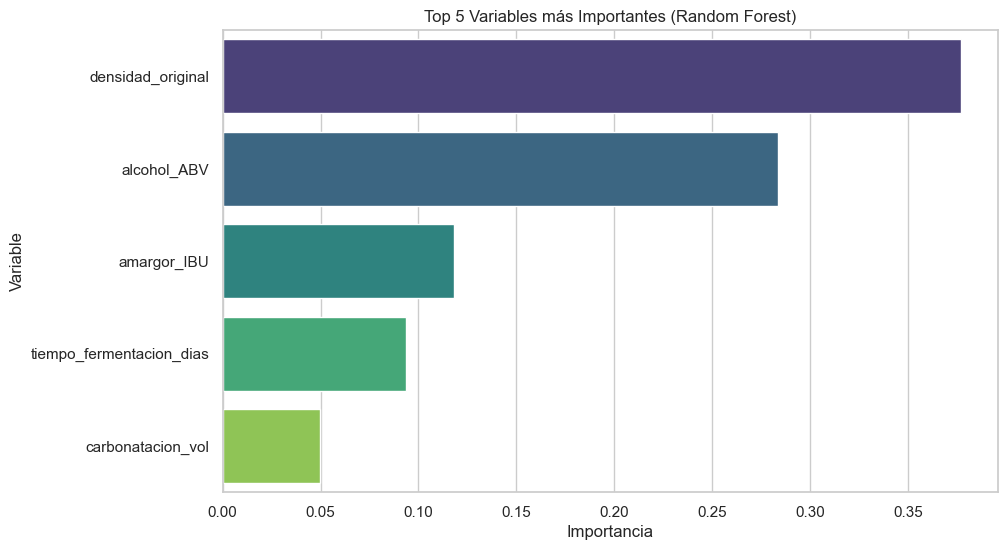

In [5]:
from sklearn.model_selection import cross_validate

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# cross validate k5
scoring = ['precision', 'recall', 'f1']
scores = cross_validate(rf_model, X_train, y_train, cv=5, scoring=scoring)

# 3. Reportar promedios
print("--- Resultados Validación Cruzada (Promedio k=5) ---")
print(f"Precision promedio: {scores['test_precision'].mean():.4f}")
print(f"Recall promedio:    {scores['test_recall'].mean():.4f}")
print(f"F1-Score promedio:  {scores['test_f1'].mean():.4f}")

# train
rf_model.fit(X_train, y_train)

# importancias
importancias = rf_model.feature_importances_
nombres_cols = X_train.columns

# df para graficar
df_importancia = pd.DataFrame({'Variable': nombres_cols, 'Importancia': importancias})
df_importancia = df_importancia.sort_values('Importancia', ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=df_importancia, palette='viridis')
plt.title('Top 5 Variables más Importantes (Random Forest)')
plt.show()

### Conclusiones y speech de ventas

#### ¿Que modelo elegiria?

Elegiría el **Random Forest**.

**Justificación:**

1. El mejor rendimiento, en el corss validatioon con k=5, el RF nos dio:
   - precisión promedio **0.9028**
   - recall promedio **0.7731**
   - F1 promedio **0.8278**
   
   Esto nos dice que el modelo mantiene tiene un buen balance entre detectar cervezas premium y no marcar de más cervezas estándar como premium.

2. **Estabilidad:** Al promediar con 5 particiones distintas de los datos, el desempeño es consistente.

3. **¿Que tan bien se interpreta?:** Contra el SVC, el Random Forest nos deja ver la importancia de cada variable. Esto es clave si el objetivo no es solo predecir, sino entender qué características hacen que una cerveza sea premium.

### 2. Comunicación al Jefe de Ventas (Cervecería Minerva)

Somos capaces de identificar las cervezas Premium con una efectividad cercana al **82.78% de F1** y una accuracy alrededor de **90.28%**, lo que significa que de cada 10 cervezas Premium, el modelo acierta casi siempre.

 
Lo más valioso para su estrategia de ventas no es solo predecir, sino lo que aprendimos sobre qué define a una cerveza Premium en el mercado de hoy en día:

1.  **El grado alcoholico lo dice todo:** Es el factor que determina en el primer puesto. Las cervezas con más cuerpo y graduación alcohólica están clasificadas casi automáticamente como Premium.
2.  **Cuerpo y Amargor:** La densidad y el amargor son los factores que siuguen en importancia. El consumidor cree que la 'experiencia Premium' se asocia con cervezas más complejas y densas, no con cervezas ligeras.

Para las próximas campañas de marketing de la línea Premium, sugiero aumentar fuertemente el **% ABV** y el perfil de cuerpo o amargor en la etiqueta, son los atributos que matemáticamente distinguen más a este segmento."